# Uniswap v2 and v3 portfolio optimisation example

- See `prefilter-finrl` on how to build the dataset
- [We hand pick 4 pairs because of missing data issues](https://github.com/AI4Finance-Foundation/FinRL/discussions/1314)


## Installation and imports

To run this notebook in google colab, uncomment the cells below.

#### Import the necessary code libraries

In [50]:
import torch

import numpy as np

from sklearn.preprocessing import MaxAbsScaler

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import GroupByScaler
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

print("Starting ok")

Starting ok


## Fetch data

In his paper, *Jiang et al* creates a portfolio composed by the top-11 cryptocurrencies based on 30-days volume. Since it's not specified when this classification was done, it's difficult to reproduce, so we will use a similar approach in the Brazillian stock market:

- We select top-10 stocks from Brazillian stock market;
- For simplicity, we disconsider stocks that have missing data for the days in period 2011-01-01 to 2019-12-31 (9 years);

In [51]:
import datetime
from pathlib import Path

import pandas as pd

from tradingstrategy.chain import ChainId
from tradingstrategy.client import Client
from tradingstrategy.timebucket import TimeBucket

chain_id = ChainId.ethereum
time_bucket = TimeBucket.h4
liquidity_time_bucket = TimeBucket.d1
min_prefilter_liquidity = 1_000_000
client = Client.create_jupyter_client()
start = datetime.datetime(2023, 1, 1)
end = datetime.datetime(2025, 1, 1)
cache_path = client.transport.cache_path

train_start = datetime.datetime(2023, 1, 1)
train_end = datetime.datetime(2024, 1, 1)

trade_start = datetime.datetime(2024, 1, 1)
trade_end = datetime.datetime(2025, 1, 1)


combined_prefilter_fname = Path(f"{cache_path}/{chain_id.get_slug()}-price-tvl-prefiltered.parquet")
policy_file = Path(f"{cache_path}/{chain_id.get_slug()}-policy.pt")
# combined_feature_fname = Path(f"{cache_path}/{chain_id.get_slug()}-features.parquet")

portfolio_raw_df = pd.read_parquet(combined_prefilter_fname)

portfolio_raw_df = portfolio_raw_df.sort_values(by=['timestamp'])

print(f"We have total {len(portfolio_raw_df['pair_id'].unique())} pairs")
print(f"Timestamp range {portfolio_raw_df['timestamp'].min()} - {portfolio_raw_df['timestamp'].max()}")
display(portfolio_raw_df[portfolio_raw_df.timestamp == pd.Timestamp("2023-01-01")].dropna())

# Don't deal with missing data yet - choose only pairs with full time series
allowed_pairs = ["WETH-USDC-v2-30", "WISE-WETH-v2-30", "UNI-WETH-v3-30", "LINK-WETH-v3-30"]

portfolio_raw_df = portfolio_raw_df[portfolio_raw_df.ticker.isin(allowed_pairs)]


Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy
We have total 141 pairs
Timestamp range 2023-01-01 00:00:00 - 2025-01-01 00:00:00


,pair_id,timestamp,open,high,low,close,volume,tvl,ticker,dex,fee
0,1,2023-01-01,1197.048924,1202.559108,1191.927648,1201.429627,6.921068e+05,3.661880e+07,WETH-USDC-v2-30,uniswap_v2,30
27816,2700159,2023-01-01,1187.308405,1192.707866,1183.779325,1190.949979,3.050945e+05,4.296140e+07,sETH2-WETH-v3-30,uniswap_v3,30
28548,2701707,2023-01-01,0.341167,0.349485,0.311281,0.334951,3.904455e+06,1.619144e+07,BIT-WETH-v3-30,uniswap_v3,30
15372,2697770,2023-01-01,1196.132013,1203.691053,1186.720266,1200.445633,1.451398e+07,3.164343e+07,WETH-USDT-v3-5,uniswap_v3,5
10248,2697610,2023-01-01,5.550532,5.621374,5.522250,5.607450,1.958343e+06,1.197425e+07,LINK-WETH-v3-30,uniswap_v3,30
16836,2698059,2023-01-01,0.387118,0.387563,0.383287,0.387324,1.765036e+05,1.229612e+07,1INCH-WETH-v3-100,uniswap_v3,100
732,239,2023-01-01,1195.185824,1204.001249,1188.307118,1202.936678,5.560654e+05,1.142700e+07,WETH-USDT-v2-30,uniswap_v2,30
2196,28202,2023-01-01,0.411992,0.411992,0.411992,0.411992,6.572122e+01,1.487704e+07,FNK-USDT-v2-30,uniswap_v2,30
5856,2697583,2023-01-01,5.160702,5.242279,5.106242,5.237424,1.599652e+06,1.617791e+07,UNI-WETH-v3-30,uniswap_v3,30
2928,29845,2023-01-01,0.100678,0.100678,0.099575,0.100189,2.210248e+05,4.236120e+07,WISE-WETH-v2-30,uniswap_v2,30


### Normalize Data

We normalize the data dividing the time series of each stock by its maximum value, so that the dataframe contains values between 0 and 1.

In [52]:
# Sklearn fit_transform() does not allow dates, so we convert timestamp to day (float) column
portfolio_prepared_df = portfolio_raw_df.copy()
first_timestamp = portfolio_prepared_df['timestamp'].min()
portfolio_prepared_df['day'] = (portfolio_prepared_df['timestamp'] - first_timestamp).dt.total_seconds() / (24 * 60 * 60)
del portfolio_prepared_df['timestamp']
del portfolio_prepared_df['pair_id']  # Cannot use numeric pair_id with GroupByScaler
 
portfolio_norm_df = GroupByScaler(by="ticker", scaler=MaxAbsScaler).fit_transform(portfolio_prepared_df)
portfolio_norm_df["timestamp"] = portfolio_raw_df["timestamp"]
display(portfolio_norm_df)


,open,high,low,close,volume,tvl,ticker,dex,fee,day,timestamp
0,0.293910,0.293241,0.299610,0.294730,0.003121,0.633168,WETH-USDC-v2-30,uniswap_v2,1,0.000000,2023-01-01
10248,0.189854,0.183305,0.191236,0.191851,0.000274,0.202644,LINK-WETH-v3-30,uniswap_v3,1,0.000000,2023-01-01
5856,0.277200,0.270944,0.290270,0.281453,0.000587,0.327282,UNI-WETH-v3-30,uniswap_v3,1,0.000000,2023-01-01
2928,0.367569,0.367569,0.365535,0.367347,0.207450,0.329550,WISE-WETH-v2-30,uniswap_v2,1,0.000000,2023-01-01
10249,0.191933,0.186726,0.192725,0.195015,0.000358,0.213252,LINK-WETH-v3-30,uniswap_v3,1,0.001368,2023-01-02
...,...,...,...,...,...,...,...,...,...,...,...
10978,0.702737,0.686060,0.689437,0.682714,0.001148,0.469036,LINK-WETH-v3-30,uniswap_v3,1,0.998632,2024-12-31
10979,0.682711,0.710052,0.682348,0.740494,0.002412,0.699041,LINK-WETH-v3-30,uniswap_v3,1,1.000000,2025-01-01
731,0.817638,0.821324,0.834180,0.823794,0.011073,0.406050,WETH-USDC-v2-30,uniswap_v2,1,1.000000,2025-01-01
3659,0.755788,0.758570,0.754930,0.754022,0.038066,0.785101,WISE-WETH-v2-30,uniswap_v2,1,1.000000,2025-01-01


In [53]:
# df_portfolio = portfolio_norm_df

df_portfolio = portfolio_norm_df[["timestamp", "ticker", "close", "high", "low"]]
df_portfolio.index.name = "Price"  # TODO: Needed?

df_portfolio_train = df_portfolio[(df_portfolio["timestamp"] >= train_start) & (df_portfolio["timestamp"] < trade_end)]
df_portfolio_trade = df_portfolio[(df_portfolio["timestamp"] >= trade_start) & (df_portfolio["timestamp"] < trade_end)]


print(f"Train range {df_portfolio_train['timestamp'].min()} - {df_portfolio_train['timestamp'].max()}")
display(df_portfolio_train)


Train range 2023-01-01 00:00:00 - 2024-12-31 00:00:00


,timestamp,ticker,close,high,low
Price,,,,,
0,2023-01-01,WETH-USDC-v2-30,0.294730,0.293241,0.299610
10248,2023-01-01,LINK-WETH-v3-30,0.191851,0.183305,0.191236
5856,2023-01-01,UNI-WETH-v3-30,0.281453,0.270944,0.290270
2928,2023-01-01,WISE-WETH-v2-30,0.367347,0.367569,0.365535
10249,2023-01-02,LINK-WETH-v3-30,0.195015,0.186726,0.192725
...,...,...,...,...,...
10977,2024-12-30,LINK-WETH-v3-30,0.703221,0.704497,0.698187
730,2024-12-31,WETH-USDC-v2-30,0.816926,0.838822,0.834225
3658,2024-12-31,WISE-WETH-v2-30,0.757624,0.765973,0.758455


### Instantiate Environment

Using the `PortfolioOptimizationEnv`, it's easy to instantiate a portfolio optimization environment for reinforcement learning agents. In the example below, we use the dataframe created before to start an environment.

In [54]:
environment = PortfolioOptimizationEnv(
    df_portfolio_train,
    initial_amount=10_000,
    comission_fee_pct=0.0050,
    time_window=50,
    features=["close", "high", "low"],
    normalize_df=None,
    time_column="timestamp",
    tic_column="ticker"
)

print(f"Portfolio optimisation for {environment.portfolio_size} assets")

Portfolio optimisation for 4 assets


### Instantiate Model

Now, we can instantiate the model using FinRL API. In this example, we are going to use the EIIE architecture introduced by Jiang et. al.

:exclamation: **Note:** Remember to set the architecture's `time_window` parameter with the same value of the environment's `time_window`.

In [55]:
# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": 50,
}

model = DRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)

### Train Model

In [56]:
DRLAgent.train_model(model, episodes=5)

 20%|██        | 1/5 [00:01<00:05,  1.30s/it]

Initial portfolio value:10000
Final portfolio value: 19786.515625
Final accumulative portfolio value: 1.9786515625
Maximum DrawDown: -0.4331534215094449
Sharpe ratio: 0.8105873556055991


 40%|████      | 2/5 [00:02<00:03,  1.31s/it]

Initial portfolio value:10000
Final portfolio value: 20269.30859375
Final accumulative portfolio value: 2.026930859375
Maximum DrawDown: -0.4357576771991126
Sharpe ratio: 0.826265154875095


 60%|██████    | 3/5 [00:03<00:02,  1.28s/it]

Initial portfolio value:10000
Final portfolio value: 20535.990234375
Final accumulative portfolio value: 2.0535990234375
Maximum DrawDown: -0.4424769360605758
Sharpe ratio: 0.8300327303676731


 80%|████████  | 4/5 [00:05<00:01,  1.27s/it]

Initial portfolio value:10000
Final portfolio value: 21095.98046875
Final accumulative portfolio value: 2.109598046875
Maximum DrawDown: -0.4418822833715401
Sharpe ratio: 0.8465063628953716


100%|██████████| 5/5 [00:06<00:00,  1.28s/it]

Initial portfolio value:10000
Final portfolio value: 22143.767578125
Final accumulative portfolio value: 2.2143767578125
Maximum DrawDown: -0.45300609318833607
Sharpe ratio: 0.8691009065160387


### Save Model

In [57]:
torch.save(model.train_policy.state_dict(), policy_file.as_posix())

## Test Model

### Instantiate different environments

Since we have three different periods of time, we need three different environments instantiated to simulate them.

In [58]:
environment_trade = PortfolioOptimizationEnv(
    df_portfolio_trade,
    initial_amount=10_000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"],
    normalize_df=None,
    time_column="timestamp",
    tic_column="ticker"    
)


### Test EIIE architecture
Now, we can test the EIIE architecture in the three different test periods. It's important no note that, in this code, we load the saved policy even though it's not necessary just to show how to save and load your model.

In [59]:
EIIE_results = {
    "training": environment._asset_memory["final"],
    "trade": {},
}

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=50, device=device)
policy.load_state_dict(torch.load("policy_EIIE.pt"))

# trade
DRLAgent.DRL_validation(model, environment_trade, policy=policy)
EIIE_results["trade"]["value"] = environment_trade._asset_memory["final"]


/var/folders/8n/h2dzh5yx5470cc6c_12dwrjw0000gn/T/ipykernel_63412/1327804178.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load("policy_EII

Initial portfolio value:10000
Final portfolio value: 11193.361328125
Final accumulative portfolio value: 1.1193361328125
Maximum DrawDown: -0.2918094938866689
Sharpe ratio: 0.41636016766020373


### Test Uniform Buy and Hold
For comparison, we will also test the performance of a uniform buy and hold strategy. In this strategy, the portfolio has no remaining cash and the same percentage of money is allocated in each asset.

In [63]:
UBAH_results = {
    "train": {},
    "trade": {},
}

PORTFOLIO_SIZE = len(df_portfolio["ticker"].unique())

# train period
terminated = False
environment.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment.step(action)
UBAH_results["train"]["value"] = environment._asset_memory["final"]

# trade perid
terminated = False
environment_trade.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_trade.step(action)
UBAH_results["trade"]["value"] = environment_trade._asset_memory["final"]

print(UBAH_results)


Initial portfolio value:10000
Final portfolio value: 21830.373046875
Final accumulative portfolio value: 2.1830373046875
Maximum DrawDown: -0.5055297001198602
Sharpe ratio: 0.8221725879295585
Initial portfolio value:10000
Final portfolio value: 13116.294921875
Final accumulative portfolio value: 1.3116294921875
Maximum DrawDown: -0.5021898420268768
Sharpe ratio: 0.6566944167040716
{'train': {'value': [10000, 10091.706, 9697.612, 9647.772, 9771.3955, 9366.015, 9235.541, 9469.902, 9338.046, 9260.842, 9625.236, 9453.48, 8953.187, 8883.727, 8989.912, 8966.869, 8963.967, 8688.706, 8132.7275, 8163.8423, 8453.663, 8844.832, 9156.959, 9389.9, 8928.257, 9049.959, 9636.892, 9613.627, 9779.2705, 9439.609, 9819.47, 9434.227, 9868.036, 9394.624, 9279.875, 9475.589, 9073.383, 9348.34, 9604.022, 9504.277, 9807.602, 9809.847, 9562.262, 9611.227, 9908.702, 10025.611, 9796.63, 9790.228, 9703.351, 9727.075, 9945.069, 9846.238, 9890.407, 10327.764, 10717.522, 10763.84, 10888.467, 10689.471, 10989.795, 102

### Compare buy-and-hold vs strategy performance in training period

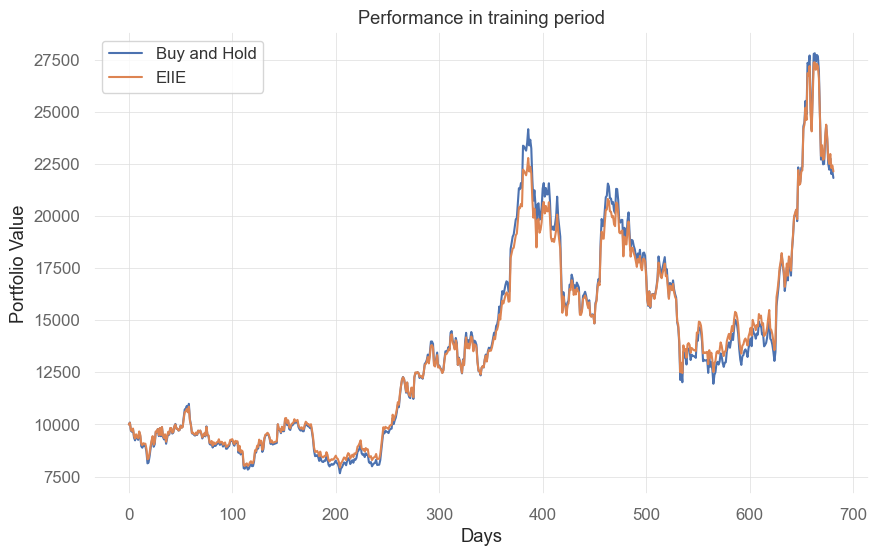

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["training"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

# Compare buy and hold vs. strategy performance in trade period

In [62]:
plt.plot(UBAH_results["2020"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2020"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2020")
plt.legend()

plt.show()

KeyError: '2020'

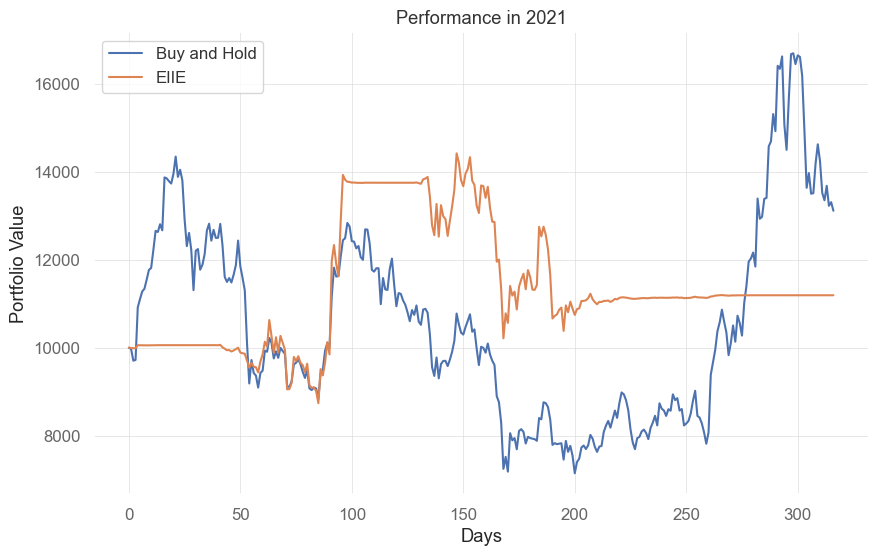

In [65]:
plt.plot(UBAH_results["trade"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["trade"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()

plt.show()